# Predicting D.C. Traffic
#### [Michael Sanders](https://michaeljsanders.com)

# Project Overview

Traffic in the District of Columbia is bad; that much is a given.  But what if you could know ahead of time just *how* bad it was going to be--*tomorrow*?

Mapping and directions apps like Google Maps, Waze, etc. already do a pretty good job of showing where the traffic is bad right now.  They also estimate travel time in traffic based on whether or not you are traveling during rush hour.

But as anyone who lives or works in the District will tell you, there are those days when the traffic is really bad... as well as some when it's surprisingly not so terrible.  What if we could predict those patterns in advance, so that you could get a sense of tomorrow morning's traffic the night before--just like a weather report.

If that were possible, what could we use to make that prediction?

In the years I've lived here, I've often wondered if there was any link between politics/government (still the city's primary industry) and traffic.  The intuition is twofold:
1. The severity of traffic is related to the total number of drivers coming into the city at roughly the same time
2. When there is an uptick in political/governmental activity, there is an increase in the aggregate number of people who come into the city.  Not just legislators, staffers, and high-level officials--there's a very large ecosystem of adjacent roles and industries--such as lobbying, catering, security, event planning, etc.--that have a role in these events and activities.

In this project, I set out create a proof of concept of the idea that, by monitoring upcoming political/government events (and any other very large events), we can adjust the probability of how bad *tomorrow's* traffic will be.

## Approach

Traffic (and transportation generally) in a major metropolitan area is a complex and highly dynamic system.  The objective is like a weather report for traffic--and I believe there is something deeper to that analogy.  Weather is highly complex, driven by the interaction of many natural processes, which are themselves complex. While I suspect traffic may not have the exact same level of complexity, it is also impacted by many diverse factors.  

With this in mind, it seemed especially important to be very deliberate about containing the scope.  This meant gathering data and selecting features with the following criteria:
- Is it logically and intuitively credible that it could impact traffic?  I'm not looking at stock market data, because how could that possibly be relevant?
- Is it "collectable" ahead of the date I'm trying to predict?  This means there need to be online sources that share date and time informaiton for upcoming events of interest.  It also means that data on crashes, Metro fires, etc. don't make sense because their impact is on the same day I'm trying to predict.
    - *A side note on Metro SafeTrack:  I considered adding that as a feature, which would have been easy to do.  I chose not to because SafeTrack was in effect during the entire period observed, so it would not have added any information.  (Think of it as being "priced in" by drivers already.)*
- Does it reasonably align with the hypothesis, by which I mean, is it political/governmental in nature, or is it some other large event (politically oriented or otherwise) that could impact the daily traffic volume.

Further, I decided to focus my analysis on *morning traffic only*.  There are numerous reasons for this, but the most compelling is that, in my experience at least, evening rush hour traffic seems to follow wholly different rules than morning traffic.  If it is predictable, I suspect it has completely different predictors.


## Data Collected

This analysis covers the time period of April 12 through May 19, 2017 (excluding weekends).  This leads to a relatively small sample size of 27 weekdays (one day's data was lost).  This was necessary given the time constraints of the current project, but it is obviously smaller than I'd like.  However, this is a living project, and I intend to maintain the data collection and retrain the model periodically to improve it.

#### Events

Informed by the scoping considerations above, I collected the following data that I thought might have some impact on traffic.  For each day:
- Was the US Senate in session before 11 a.m.
- Was the US House of Representatives in session before 11 a.m.
- How many Senate committee hearings began before 11 a.m.
- How many House committee hearings began before 11 a.m.
- How many events at the Walter Washington Convention Center began before 11 a.m.
- How many events at the Ronald Reagan Building began before 11 a.m.

I had hoped to gather similar information about White House / Presidential activities.  However, the current administration has broken with precedent and no longer publishes the President's public schedule online.

#### Traffic
To collect traffic information, I utilized the [Google Maps Distance Matrix API](https://developers.google.com/maps/documentation/distance-matrix/).  This API returns distance, duration, and duration in traffic for a given route.  I compiled a list of 24 major traffic arteries within the District and gathered duration data from the API between 7 a.m. and 10 a.m. in 10-minute intervals.

The blue lines on the satellite image below depict the routes that were tracked.  All routes were defined as "outside-in" in order to measure "with traffic" commuting times.  That is, the origin was the point furthest from the city center, and the destination was closest to the city center for a given route.  

![Map of roads where traffic data was collected](routes_smaller.jpg)



## Results Summary

After numerous iterations of regression modeling and classification modeling, I came to the following results:
Using classification algorithms, the events data seems to provide a reasonably reliable predictor of whether a given day's traffic will be:
- Above or below the median
- Unusually bad 
- Unusually less bad 


|Prediction |Precision Score |Interpretation|
|:---|:--:|:---|
|Tomorrow's traffic will be ABOVE the median  |.67 | 67% chance the prediction is correct |
|Tomorrow's traffic will be BELOW the median |.83 | 83% chance the prediction is correct  |
|Tomorrow's traffic will be VERY BAD  |.86 |86% chance the prediction is correct |
|Tomorrow's traffic will NOT be VERY BAD  |.50 |50% chance the prediction is correct |
|Tomorrow's traffic will be relatively LESS BAD    |.88 |88% chance the prediction is correct |
|Tomorrow's traffic will NOT be relatively LESS BAD  |1.0 |100% chance the prediction is correct*

* *Obviously 100% is unlikely, and it is probably due to the small sample size.  However, what matters is that the model is tuned to be "suspicious" that the traffic will be less bad.  A bad prediction on this category could mean someone (like me) doesn't leave the house early enough and arrives late.*

Another side note:  I had hoped to be able to predict the *amount* of traffic delay in time (regression modeling), but it was unsuccessful.  However, given the small sample size, I don't believe that the results of this exercise disprove the ability to predict traffic times with this data.  I will test this again once I've collected enough more data.

If you are interested in seeing how I built the models that generated these results, please continue reading!

## Project Next Steps

I consider this to be a living project and plan to continue developing and refining it.  In particular, I plan to continue gathering data to build a larger, more significant dataset to model against.  I'll use this data to retrain the current models, as well as explore whether the additional data allows for greater results using different methods (maybe even regression will work).

# Data Analysis and Modeling

## Exploratory Data Analysis

For this notebook, there are two csv files containing the compiled, cleaned output of all the data gathered.  One file has all of the event data, the other has the traffic data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
plt.style.use('ggplot')
%matplotlib inline

In [2]:
# Load in the data I've already pulled, scraped, scrimped, begged, and borrowed...
events_data = pd.read_csv('events_data.csv')
traffic_data = pd.read_csv('traffic_data.csv')

### Events Data

Congressional-related data was scraped from several government websites (such as the House Majority Leader's website, Senate.gov, the Congressional Record, and Senate committee pages).  Convention center event data was scraped from the [Events DC website](http://eventsdc.com), and [Reagan Building](http://itcdc.com) event data was scraped from its website.

Senate_AM_session and House_AM_session are binary values: 1 if the chamber was in session before 11 a.m., 0 if not.

Day_of_week represents weekdays, from 0=Monday to 6=Sunday (generated using `pandas.DatetimeIndex.dayofweek`).

In [3]:
# Taking a look at the events data:
events_data.head()

,Date,Senate_AM_session,House_AM_session,House_AM_hearings,Senate_AM_hearings,ConvCtr_Events,ReaganCtr_Events,Day_of_week
0,4/12/17,0,1,0,0,1,1,2
1,4/13/17,1,0,0,0,1,1,3
2,4/14/17,0,1,0,0,0,1,4
3,4/15/17,0,0,0,0,0,0,5
4,4/16/17,0,0,0,0,0,0,6


In [4]:
# Confirming there are no missing values
print "Number of missing values per column:\n"
print events_data.isnull().sum()

Number of missing values per column:

Date                  0
Senate_AM_session     0
House_AM_session      0
House_AM_hearings     0
Senate_AM_hearings    0
ConvCtr_Events        0
ReaganCtr_Events      0
Day_of_week           0
dtype: int64


In [5]:
# 'Day_of_week' is coded 0 - 6, with 0=Monday and 6=Sunday
print "Number of observations by day of the week (0=Monday thru 6=Sunday)\n"
print events_data.Day_of_week.value_counts()

Number of observations by day of the week (0=Monday thru 6=Sunday)

4    6
3    6
2    6
6    5
5    5
1    5
0    5
Name: Day_of_week, dtype: int64


In [6]:
# Dropping weekends from the events data, and also removing 5/16 since the traffic data from that day was lost.
events_data = events_data[(events_data.Day_of_week != 5) & (events_data.Day_of_week != 6)].copy()
events_data = events_data[events_data.Date != '2017-05-16'].copy()
events_data.Date = pd.to_datetime(events_data.Date)

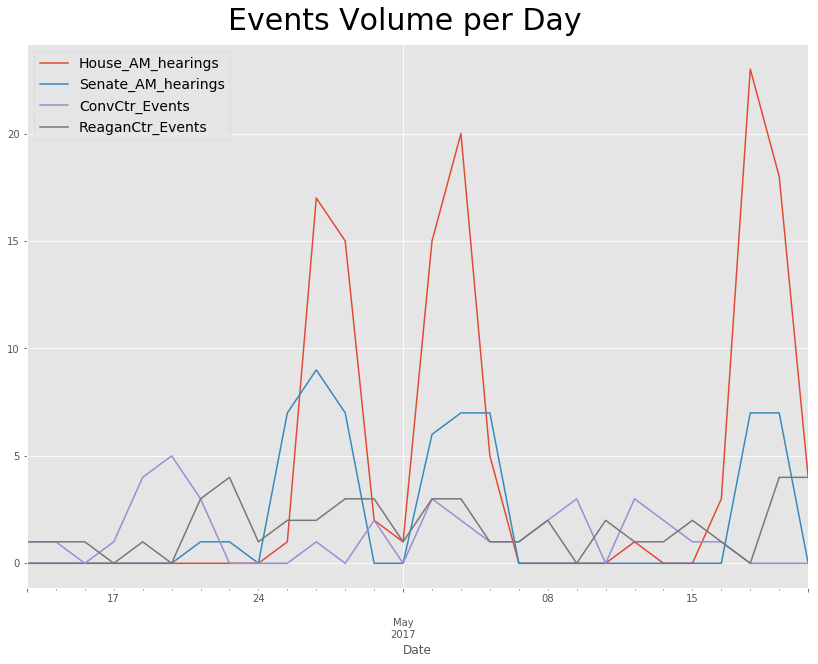

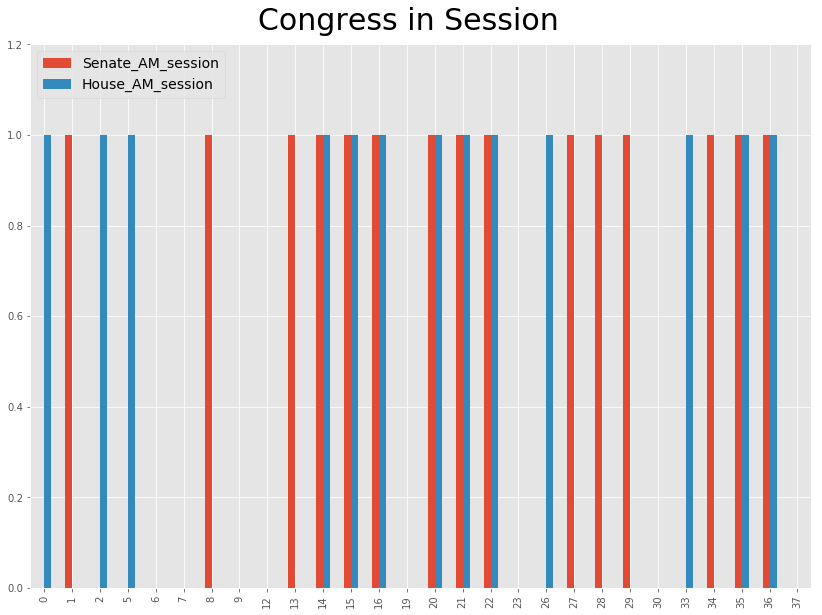

In [7]:
# Visualizing volume of events during the time period 

events_data.drop(['Day_of_week','Senate_AM_session', 'House_AM_session'], 
                 axis=1).plot(x=events_data.Date, figsize=(14,10))
plt.figtext(.5,.9,'Events Volume per Day', fontsize=30, ha='center')
plt.legend(loc=2,prop={'size':14})
events_data[['Senate_AM_session', 'House_AM_session']].plot(figsize=(14,10), ylim=(0,1.2),
                                                            kind='bar')
plt.figtext(.5,.9,'Congress in Session', fontsize=30, ha='center')
plt.legend(loc=2,prop={'size':14})

### Traffic Data

Traffic data was collected using the [Google Maps Distance Matrix API](https://developers.google.com/maps/documentation/distance-matrix/).  This API returns distance, duration, and duration in traffic for a given route.  I compiled a list of 24 major traffic arteries within the District and gathered duration data from the API between 7 a.m. and 10 a.m. in 10-minute intervals.

The Duration_in_Traffic field is returned by Google, and it represents their estimate of the actual travel time given current traffic conditions.  Because each route has a different length (Distance_km), I standardized both the Duration and Duration_in_Traffic values on a minutes-per-kilometer scale. The column per_km_std maps to Duration, and per_km_traffic maps to Duration_in_Traffic.

Finally, I calculated an overall measure of traffic intensity ("traffic badness"?) for each observation, which is simply per_km_traffic minus per_km_std. The result is in the column labeled traffic_delay_std.

In [8]:
traffic_data.head()

,DateTime,Distance_km,Duration,Duration_in_Traffic,entry,Date,traffic_delay_raw,per_km_std,per_km_traffic,route,Date_clean,traffic_delay_std
0,2017-04-12 07:04,2.652,5.366667,5.216667,BenningApr12070429,Apr12070429,-0.150000,2.02363,1.967069,Benning,2017-04-12,-0.056561
1,2017-04-12 07:14,2.652,5.366667,5.516667,BenningApr12071436,Apr12071436,0.150000,2.02363,2.080191,Benning,2017-04-12,0.056561
2,2017-04-12 07:24,2.652,5.366667,5.783333,BenningApr12072442,Apr12072442,0.416667,2.02363,2.180744,Benning,2017-04-12,0.157114
3,2017-04-12 07:34,2.652,5.366667,6.116667,BenningApr12073448,Apr12073448,0.750000,2.02363,2.306435,Benning,2017-04-12,0.282805
4,2017-04-12 07:44,2.652,5.366667,7.000000,BenningApr12074456,Apr12074456,1.633333,2.02363,2.639517,Benning,2017-04-12,0.615887


In [9]:
# Confirming there are no missing values
print "Number of missing values per column:\n"
print traffic_data.isnull().sum()

Number of missing values per column:

DateTime               0
Distance_km            0
Duration               0
Duration_in_Traffic    0
entry                  0
Date                   0
traffic_delay_raw      0
per_km_std             0
per_km_traffic         0
route                  0
Date_clean             0
traffic_delay_std      0
dtype: int64


An interesting quirk of the data:  the values for Duration for a given route are NOT 100% identical.  I was unable to find a definitive explanation in Google's documentation or elsewhere.  My best hypothesis was that Duration takes into account some amount of historical traffic data into consideration.  However, this is not a totally satisfying answer, since that is the purpose of Duration_in_traffic.

In order to decide whether this discrepancy was enough to invalidate the data, I looked at the degree to which these values were different.  To make an apples-to-apples comparison, I focused on the per_km_std column, which standardizes duration on the per-kilometer scale (eliminating the issue of different routes having different distances).

As you will see below, the differences for a single given route are very minimal.  Although it is not as clean as I would like, I decided to proceed with this data.

In [10]:
duration_diffs = traffic_data.groupby('route').per_km_std.agg(['min', 'max', 'std'])
print duration_diffs

                  min       max       std
route                                    
Benning      2.023630  2.055053  0.011026
Bladensburg  2.647916  3.170382  0.082684
Canal        1.274254  1.993403  0.146336
ConnAve      2.564401  2.849158  0.020893
Const        2.419110  3.057313  0.059276
EastCap      1.981425  2.385534  0.069867
Fourteenth   2.696046  3.593843  0.188875
GeorgiaAve   2.656209  2.673785  0.006871
I295         0.700207  1.909009  0.108891
I395         0.851740  0.858958  0.003493
I695         0.758508  2.447973  0.257471
Indep        1.814798  2.322903  0.044247
Kst          3.684352  4.414030  0.038527
MDAve        3.049576  3.731450  0.039948
MassAve      2.531103  3.100231  0.074369
NH           2.504380  2.983911  0.107653
NYAve        1.756104  3.168643  0.153937
NorthCap     2.213838  2.955588  0.119357
PennSE       2.099338  2.421455  0.034403
RIAve        2.664181  3.250786  0.081533
SCap         1.809182  2.825812  0.065170
Sixteenth    2.307982  2.573329  0

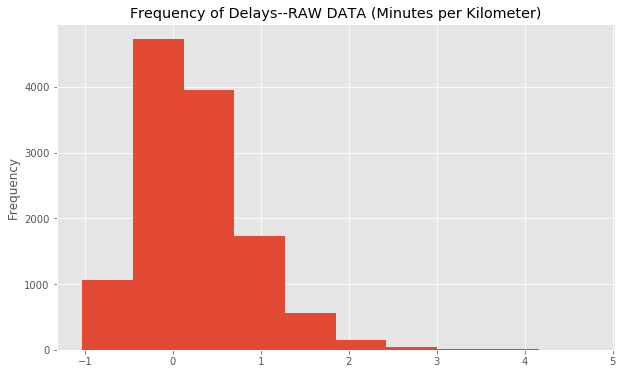

In [11]:
# Overall, what do the delays look like?  (This is at the most granular level.)

traffic_data.traffic_delay_std.plot(kind='hist', figsize=(10,6), 
                                    title='Frequency of Delays--RAW DATA (Minutes per Kilometer)')

We can see that most delays are tightly grouped, with a left skew.  Interestingly, there are "negative" delays--these are instances where Google predicted that the duration in traffic would be *less* than the standard duration.  This lends some credence to the idea that the "standard" duration field incorporates non-fixed data (e.g., somthing other than distance, speed limits, number of stop signs/lights, etc.).

In [12]:
# Creating new dataframe showing the mean traffic delay per route per day (routes as columns)
delay_per_km = pd.DataFrame(traffic_data.pivot_table(index=traffic_data.Date_clean, 
                                                columns=traffic_data.route, values='traffic_delay_std'))

In [13]:
delay_per_km.head()

route,Benning,Bladensburg,Canal,ConnAve,Const,EastCap,Fourteenth,GeorgiaAve,I295,I395,...,MassAve,NH,NYAve,NorthCap,PennSE,RIAve,SCap,Sixteenth,Whitehurst,WiscAve
Date_clean,,,,,,,,,,,,,,,,,,,,,
2017-04-12,0.131278,-0.014457,0.428804,0.031045,0.094243,0.263718,0.255276,-0.214699,0.364992,0.291131,...,0.220567,0.514995,0.782595,0.713790,0.057699,0.455870,0.165937,0.288226,0.117800,-0.360247
2017-04-13,0.743674,0.191381,0.212537,-0.101399,-0.008785,0.244916,0.307179,-0.178936,0.259096,0.234589,...,0.193484,0.412262,0.832356,0.576292,0.198736,0.417803,0.366957,0.300384,0.322097,-0.369013
2017-04-14,-0.147338,-0.207215,-0.146089,-0.433924,-0.193545,-0.094545,-0.131309,-0.483469,-0.000720,0.055339,...,-0.281559,0.011763,0.281316,0.137887,-0.287504,-0.185783,-0.139861,-0.142422,0.019771,-0.583776
2017-04-17,-0.277513,-0.237396,-0.010974,-0.093937,-0.016646,-0.118781,-0.418649,-0.624188,0.188929,0.094975,...,-0.145429,-0.119865,0.147791,-0.037715,-0.434143,-0.237701,0.146873,0.065865,0.600924,-0.564570
2017-04-18,0.003638,-0.130438,0.661270,-0.128045,0.032788,0.040452,0.034657,-0.413967,0.751847,0.230220,...,0.308664,0.103228,0.610637,0.432227,0.110600,0.298689,0.357974,0.179959,0.647749,-0.289987


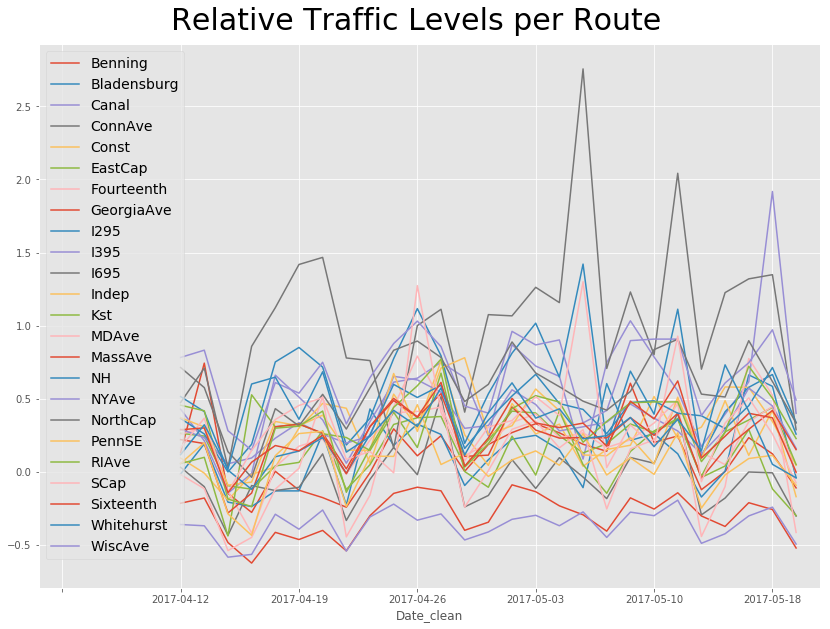

In [14]:
# What was the traffic like day over day?
delay_per_km.plot(figsize=(14,10), xlim=(-6,27))
plt.figtext(.5,.9,'Relative Traffic Levels per Route', fontsize=30, ha='center')
plt.legend(loc=2,prop={'size':14})

Although the chart is visually busy, it does appear that the different routes move more or less together over time.  They differ significantly in intensity, but there is a generally consistency to the shape.

In order to make this data useful for modeling purposes, I needed to aggregate it by date, so that I would have an overall picture of relative traffic "badness" on each date.  To do this, I created a pivot table with date as the index and a column for each route, containing that day's mean traffic measurement.  I then took the mean of those means, which is used for the actual modeling.

In [15]:
# Consolidated mean delay across routes -- this is what will ultimately become our target variable.
mean_delay_km = pd.DataFrame(traffic_data.groupby(['Date_clean']).traffic_delay_std.agg('mean'))

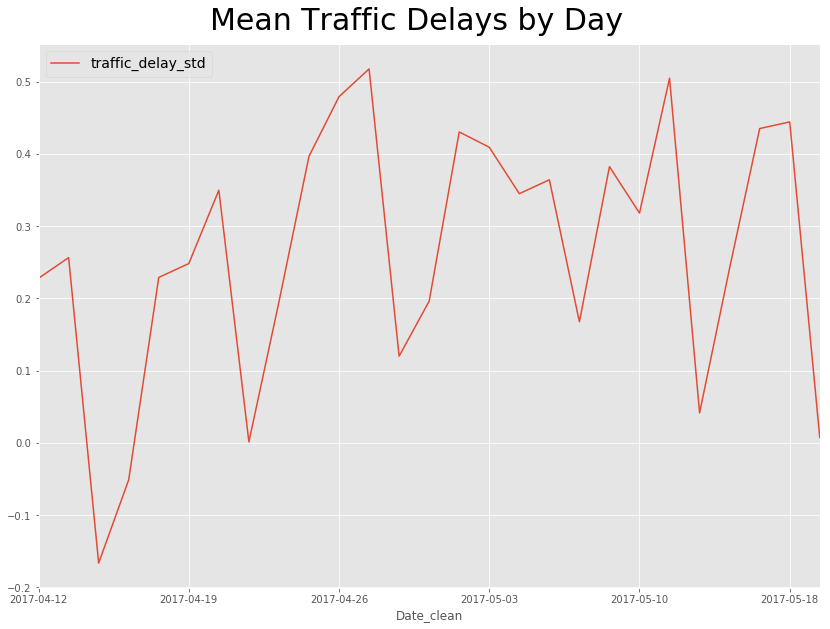

In [16]:
mean_delay_km.plot(figsize=(14,10))
plt.figtext(.5,.9,'Mean Traffic Delays by Day', fontsize=30, ha='center')
plt.legend(loc=2,prop={'size':14})

This is the "smoothed" view of overall traffic per day.  

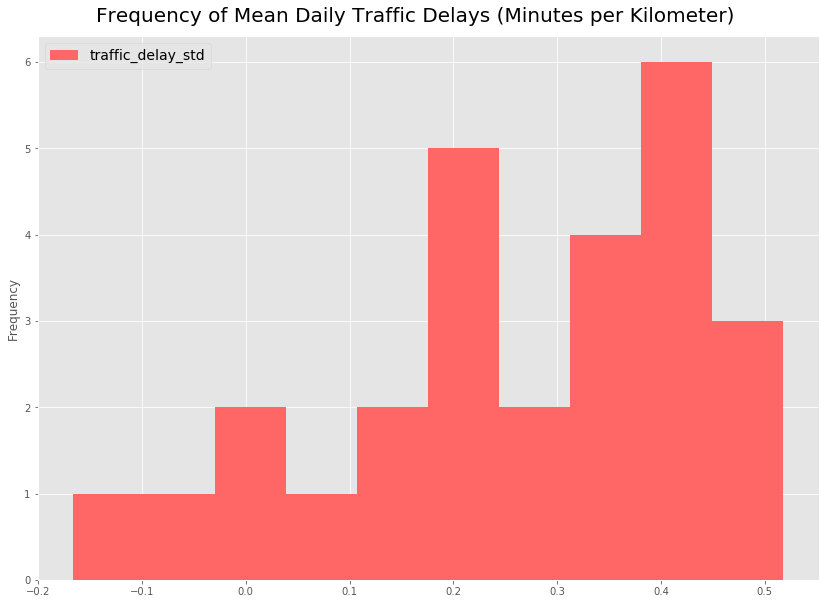

In [17]:
mean_delay_km.plot(figsize=(14,10), kind='hist', color='#ff6666')
plt.figtext(.5,.9,'Frequency of Mean Daily Traffic Delays (Minutes per Kilometer)', fontsize=20, 
            ha='center')
plt.legend(loc=2,prop={'size':14})

Note how the distribution flipped from before.  It is tighter in terms of length of delay (0.5 as opposed to about 4) because we are looking at an average of averages.  But this is quite useful in that it shows us the frequency of these delays at a daily observational unit--which is what I'm trying to predict.

## Data Preprocessing

Before modeling, I need to convert the day of week variable into binary dummy variables, generate my three categories of target y variables (above/below median, very bad, less bad), and set up a train/test split.

In [18]:
weekday_dummies = pd.get_dummies(events_data.Day_of_week)
weekday_dummies.drop(4, axis=1, inplace=True) # Drop one dummy column
events_data = pd.concat([events_data, weekday_dummies], axis=1)
events_data.drop('Day_of_week', axis=1, inplace=True)

In [19]:
mean_delay_km['Date'] = pd.to_datetime(mean_delay_km.index)
full_df = pd.merge(events_data, mean_delay_km, left_on='Date', right_on='Date')
full_df.drop('Date', axis=1, inplace=True)
full_df.rename(columns={0:'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday'}, inplace=True)

In [20]:
full_df.head()

,Senate_AM_session,House_AM_session,House_AM_hearings,Senate_AM_hearings,ConvCtr_Events,ReaganCtr_Events,Monday,Tuesday,Wednesday,Thursday,traffic_delay_std
0,0,1,0,0,1,1,0,0,1,0,0.227957
1,1,0,0,0,1,1,0,0,0,1,0.256522
2,0,1,0,0,0,1,0,0,0,0,-0.166355
3,0,1,0,0,1,0,1,0,0,0,-0.051037
4,0,0,0,0,4,1,0,1,0,0,0.229106


For target variable definition, I am going to be classifying based on the median of mean traffic delays.  Because the distribution of mean delays is left-skewed, it is more appropriate to use the more robust statistic of median at this stage.

In [21]:
# SD of traffic time
std = np.std(full_df.traffic_delay_std)
print std

# Median of traffic time
med = np.median(full_df.traffic_delay_std)
print med

0.177361318793
0.25652191537


I am going to see if we can predict traffic in three categories:
- Basic measure of whether the traffic is above or below the median.
- Prediction of whether the traffic will be "very bad" defined as being >= the median + one standard deviation
- Prediction of whether the traffic will be "good" ("less bad" is probably more apt), defined as being <= the median - one standard deviation

In [22]:
# Creating my target variable columns based on the definitions above.
full_df['basic'] = full_df.traffic_delay_std.map(lambda x: 1 if x >= med else 0)
full_df['very_bad'] = full_df.traffic_delay_std.map(lambda x: 1 if x >= med + std else 0)
full_df['good'] = full_df.traffic_delay_std.map(lambda x: 1 if x <= med - std else 0)

In [23]:
# Setting up my explanatory data (X), and my y targets
X = full_df.drop(['traffic_delay_std', 'basic', 'very_bad', 'good'], axis=1).copy()
ybasic = full_df.basic.copy()
yvbad = full_df.very_bad.copy()
ygood = full_df.good.copy()

In [24]:
ybasic.value_counts()

1    14
0    13
Name: basic, dtype: int64

In [25]:
yvbad.value_counts()

0    22
1     5
Name: very_bad, dtype: int64

In [26]:
ygood.value_counts()

0    22
1     5
Name: good, dtype: int64

The more extreme traffic conditions ('good' and 'very bad') are more rare, therefore we have unbalanced classes.  Because of this, I will stratify the y for those two versions (but not for 'basic' since it is split on the median).

In [27]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

Xbasic_train, Xbasic_test, ybasic_train, ybasic_test = train_test_split(X, ybasic, test_size = .33, random_state = 2)
Xvbad_train, Xvbad_test, yvbad_train, yvbad_test = train_test_split(X, yvbad, test_size = .33, stratify = yvbad, random_state = 2)
Xgood_train, Xgood_test, ygood_train, ygood_test = train_test_split(X, ygood, test_size = .33, stratify = ygood, random_state = 2)

## Modeling

Since this is a classification exercise, my interest is only partially in accuracy score.  I'm far more interested in precision.  Why?  Consider the use case:  If someone were to make a decision based on the prediction of this model, but got a false negative or false posiive (depending on the category), they might end up being late for a meeting if they falsely believed traffic was going to be light. That could be *worse* than a high generalized accuracy score.

After experimenting with various classifiers, I settled on Naive Bayes (for above/below median) and Logistic Regression (for the others).  In addition to their performance on the data itself, I see advantages in each model:
- Naive Bayes is well suited for small sample sizes, as is Bayesian statistics in general.
- Logistic regression is a theoretically solid method and maintains interpretability.  

I also tried Random Forest and XGBoost, for example.  But I found that in some cases they produced nearly identical results as NB or LG, and in other cases their performance was abjectly horrible.

Below is the code and outputs for the best performing models.

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

In [29]:
# Model evaluation function that trains and tests the model, and generates the corresponding reports.
def evaluate_model(m, X, y, X_train, X_test, y_train, y_test):
    model = m.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test,y_pred,labels =[1,0])
    class_report = classification_report
    print m,'\n'
    print "Accuracy Score:\t{:0.3}".format(score.round(3)),'\n\n'
    crossval = cross_val_score(m, X, y,cv=5, n_jobs=-1)
    print "Cross Val Scores:", crossval,'\n'
    print "Cross Val mean ± Std. Dev:{:0.3}".format(np.mean(crossval), ' ± ',np.std(crossval)),'\n'
    print "Population Totals:"
    for i,v in enumerate(np.bincount(y)):
        print "class "+str(i)+':' , v
    print "\nConfusion Matrix:"
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=['Actual 1', 'Actual 0'],
                         columns=['Predicted 1','Predicted 0'])
    print(confusion),'\n'
    print "Classification Report:"
    print(classification_report(y_test, y_pred, target_names=['1','0']))
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specificity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

### Category 1: Predicting whether the Traffic Will Be Above or Below the Median
- 1 = Above median
- 0 = Below median

BernoulliNB(alpha=1, binarize=0.0, class_prior=None, fit_prior=True) 

Accuracy Score:	0.778 


Cross Val Scores: [ 1.          1.          0.66666667  0.6         1.        ] 

Cross Val mean ± Std. Dev:0.853 

Population Totals:
class 0: 13
class 1: 14

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1            5            1
Actual 0            1            2 

Classification Report:
             precision    recall  f1-score   support

          1       0.67      0.67      0.67         3
          0       0.83      0.83      0.83         6

avg / total       0.78      0.78      0.78         9



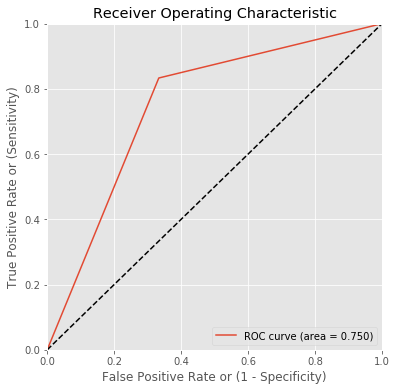

In [30]:
# After much tuning with GridSearchCV, the out-of-box parameters worked best.

BernNB = BernoulliNB(alpha=1)
evaluate_model(BernNB, X, ybasic, Xbasic_train, Xbasic_test, ybasic_train, ybasic_test)

### Category 2: Predicting whether the Traffic Will Be Very Bad
- 1 = Very Bad = Traffic is >= median + 1 standard deviation
- 0 = Not Vey Bad = Traffic is < median + 1 standard deviation

Logistic regression works well here, although BernoulliNB and some ensembe methods perform almost identically. This is likely related to the small sample size, especially the small test set size.  GridSearchCV was not helpful here, as I wanted to score on precision, but the data was insufficient to support it.  Through manual tuning and testing, I determined that out-of-box parameters again worked well.  This will likely evolve as more data is collected and I retrain the models.

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

Accuracy Score:	0.778 


Cross Val Scores: [ 0.83333333  1.          0.4         0.8         1.        ] 

Cross Val mean ± Std. Dev:0.807 

Population Totals:
class 0: 22
class 1: 5

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1            1            1
Actual 0            1            6 

Classification Report:
             precision    recall  f1-score   support

          1       0.86      0.86      0.86         7
          0       0.50      0.50      0.50         2

avg / total       0.78      0.78      0.78         9



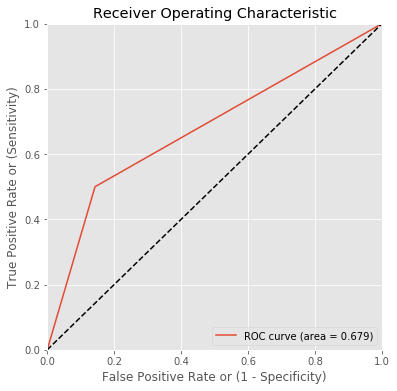

In [31]:
logreg = LogisticRegression(n_jobs=-1) # I always set n_jobs to -1 when it's an option b/c it will use all 
                                    # processor cores and potentially speed up the computation.
evaluate_model(logreg, X, yvbad, Xvbad_train, Xvbad_test, yvbad_train, yvbad_test)

Category 2: Predicting whether the Traffic Will Be (Relatively) Good
- 1 = Good = Traffic is <= median - 1 standard deviation
- 0 = Not Good = Traffic is > median - 1 standard deviation

Similar to the model for very bad traffic, manual tuning was necessary.  For the "good" traffic prediction, I am especially focuse on maximizing precision, since I want to *minimize false positives*. The practical risk of a false positive is that a user could believe the that traffic would be light and, say, leave for work a little later.  If this were a false positive, that user could end up being late for work.

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

Accuracy Score:	0.889 


Cross Val Scores: [ 1.          0.83333333  0.8         0.8         0.8       ] 

Cross Val mean ± Std. Dev:0.847 

Population Totals:
class 0: 22
class 1: 5

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1            1            1
Actual 0            0            7 

Classification Report:
             precision    recall  f1-score   support

          1       0.88      1.00      0.93         7
          0       1.00      0.50      0.67         2

avg / total       0.90      0.89      0.87         9



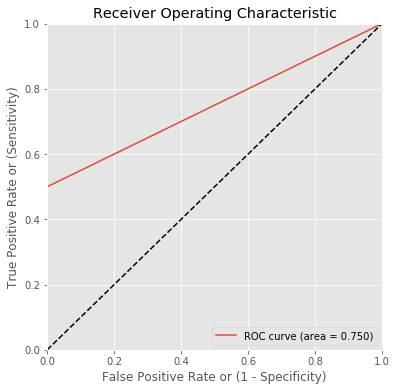

In [32]:
logreg2 = LogisticRegression(C=2)
evaluate_model(logreg2, X, ygood, Xgood_train, Xgood_test, ygood_train, ygood_test)